# Training from a frozen base

In [1]:
%matplotlib inline

import os
import numpy as np

import matplotlib.pyplot as plt

from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
vgg = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3))

In [3]:
vgg.summary() #https://arxiv.org/abs/1409.1556

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

~15 million params

In [4]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [5]:
val_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_data_gen = train_gen.flow_from_directory(
    r"D:\Data_sets\dogscats\train",
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 23000 images belonging to 2 classes.


11500 cats and 11500 dogs

In [7]:
val_data_gen = val_gen.flow_from_directory(
    r"D:\Data_sets\dogscats\valid",
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [8]:
model = models.Sequential()
model.add(vgg) #Add a model just like a layer
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


~ extra 2 million params in fully connected layers.

In [10]:
model.trainable_weights

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv3

In [11]:
len(model.trainable_weights)

30

In [12]:
vgg.trainable = False #Freeze

In [13]:
len(model.trainable_weights)

4

In [14]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [15]:
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=val_data_gen,
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 21s 215ms/step - loss: 0.6014 - acc: 0.6795 - val_loss: 0.4568 - val_acc: 0.8130
Epoch 2/30
100/100 [==============================] - 17s 175ms/step - loss: 0.4867 - acc: 0.7725 - val_loss: 0.3848 - val_acc: 0.8340
Epoch 3/30
100/100 [==============================] - 17s 172ms/step - loss: 0.4415 - acc: 0.8020 - val_loss: 0.3621 - val_acc: 0.8420
Epoch 4/30
100/100 [==============================] - 17s 169ms/step - loss: 0.4229 - acc: 0.8085 - val_loss: 0.3350 - val_acc: 0.8580
Epoch 5/30
100/100 [==============================] - 17s 170ms/step - loss: 0.4002 - acc: 0.8240 - val_loss: 0.3163 - val_acc: 0.8690
Epoch 6/30
100/100 [==============================] - 17s 174ms/step - loss: 0.3865 - acc: 0.8230 - val_loss: 0.3064 - val_acc: 0.8670
Epoch 7/30
100/100 [==============================] - 18s 176ms/step - loss: 0.3849 - acc: 0.8255 - val_loss: 0.3028 - val_acc: 0.8710
Epoch 8/30
100/100 [==============================] - 1

The fully connected layers are trained and the model has 89.9% accuracy

To further improve, lets fine tune the top of the vgg model:

In [16]:
vgg.layers

In [17]:
vgg.layers[-2].name

'block5_conv3'

In [18]:
vgg.trainable = True

In [19]:
for layer in vgg.layers:
    if layer.name == 'block5_conv3':
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
len(model.trainable_weights)

6

In [21]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

In [22]:
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=val_data_gen,
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 20s 196ms/step - loss: 0.3144 - acc: 0.8540 - val_loss: 0.2508 - val_acc: 0.8970
Epoch 2/30
100/100 [==============================] - 19s 186ms/step - loss: 0.2993 - acc: 0.8675 - val_loss: 0.2450 - val_acc: 0.8990
Epoch 3/30
100/100 [==============================] - 19s 188ms/step - loss: 0.3146 - acc: 0.8640 - val_loss: 0.2411 - val_acc: 0.9040
Epoch 4/30
100/100 [==============================] - 18s 177ms/step - loss: 0.3209 - acc: 0.8610 - val_loss: 0.2537 - val_acc: 0.8970
Epoch 5/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3117 - acc: 0.8620 - val_loss: 0.2339 - val_acc: 0.9050
Epoch 6/30
100/100 [==============================] - 18s 179ms/step - loss: 0.3022 - acc: 0.8660 - val_loss: 0.2290 - val_acc: 0.9050
Epoch 7/30
100/100 [==============================] - 18s 176ms/step - loss: 0.3005 - acc: 0.8675 - val_loss: 0.2247 - val_acc: 0.9020
Epoch 8/30
100/100 [==============================] - 1

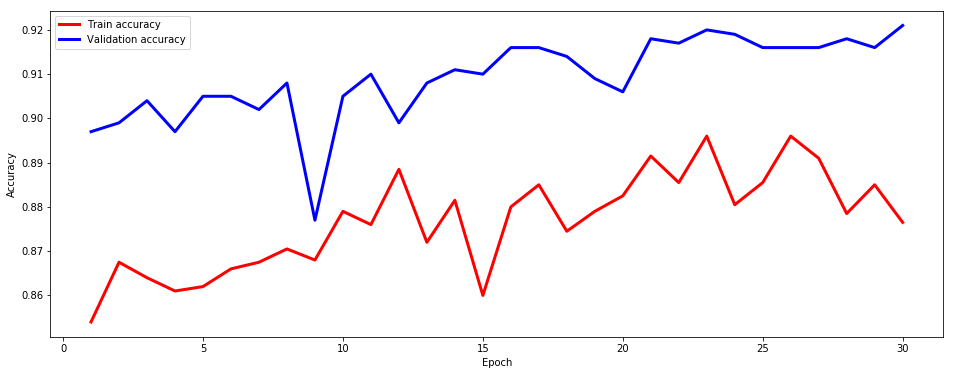

In [23]:
hist_dict = history.history

losses = hist_dict['loss']
val_losses = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.figure(figsize=(16,6))
plt.plot(range(1,31), acc, 'r', label='Train accuracy', linewidth=3)
plt.plot(range(1,31), val_acc, 'b', label='Validation accuracy', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

Augmentation causes the training accuracy to fall below the validation accuracy (it is turned off when validating).

In [26]:
model.save('cats_dogs_vgg.h5')